# 3. Parameter Estimation for the Gamma Conjugate Prior
In this notebook, parameters for the gamma conjugate prior (GCP) are estimated using the
*least surprise estimate*, that is, by minimizing the maximum Kullback-Leibler distance
of the GCP to any of the regional distributions.


## Configuration
First, the configuration of the fitting algorithm. As described in the REHEATFUNQ model
description paper, the algorithm proceeds by randomly distributing disks across a spherical
Earth, and for each disk selecting data from the filtered global heat flow database that
are within the disk. The following parameters control the disk size and the disk acceptance
criterion:

| Parameter    | Purpose                                                                                       |
| :---------   | :-------------------------------------------------------------------------------------------- |
| `R`          | Radius of the disks, in meters.                                                               |
| `DMIN_KM`    | Minimum distance between two data points in km. Select one of each violating pair at random.  |
| `min_points` | Minimum number of selected points. Reject proposed disks if less selected points within.      |

In [1]:
R = 80e3
DMIN_KM = 20
min_points = 10

## Package imports:

In [2]:
import shapely
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj
from pathlib import Path
from zeal2022hf import kindlmann, kindlmann_r
from loaducerf3 import PolygonSelector, Polygon
from pdtoolbox.distributions import *
from pdtoolbox.mle import *
from pdtoolbox.likelihood import *
from pickle import Pickler, Unpickler
from cache import cached_call
from reheatfunq.coverings import random_global_R_disk_coverings
from reheatfunq import GammaConjugatePrior
from reheatfunq.regional.backend import gamma_mle

Figure style configurations:

In [63]:
from matplotlib import rcParams
rcParams["text.usetex"] = False
rcParams['font.family'] = 'sans'
rcParams['text.latex.preamble'] = "\\renewcommand{\\familydefault}{\\sfdefault}\n\\usepackage{helvet}"
rcParams['font.size'] = 10

Configure plots to look good on a HiDPI monitor (you may not need the following configuration if you are not using a HiDPI monitor):

In [4]:
%config InlineBackend.figure_format = 'retina'

## Dataset
Load the data set processed in `01-Load-and-filter-NGHF.ipynb`

In [5]:
hf_continental = np.load('data/heat-flow-selection-mW_m2.npy')

### Exclude areas used in regional analyses
Load the selectors that will later select the regional aggregate heat flow distributions.
These polygon selectors have been defined in `02-Study-Area-Geometry.ipynb`.

In [6]:
with open('export/02-Geometry.pickle','rb') as f:
    saf_geometry = Unpickler(f).load()

proj_saf = Proj(saf_geometry["proj_str"])

In [7]:
mask = np.ones(hf_continental.shape[1], dtype=bool)
hf_xy = np.stack(proj_saf(*hf_continental[1:3,:]), axis=1)

for poly in saf_geometry["selection_polygons_xy"]:
    select = PolygonSelector(Polygon(*poly[:-1].T))
    mask &= ~select.array_mask(hf_xy)
hf_independent = (hf_continental.T)[mask]

### Back-indexing to the NGHF data set
Compute the indices of the masked data within the original NGHF data set (Lucazeau, 2019)
for simple reproducibility. This might or might not be relevant for applications to other
areas and/or data sets.

In [8]:
hf_continental_indices = np.loadtxt('export/nghf-selection-indices.csv', delimiter=',', dtype=int)

# We also have to update the indices into hf_continental now:
local2continental = np.arange(mask.size)[mask]
local2lucazeau = hf_continental_indices[local2continental]
lucazeau2local = {i : j for i,j in enumerate(local2lucazeau)}

### Create a disk-buffer around the polygons
In the later analysis based on the random distribution of disks all over
Earth surface, we want to prevent the disks from overlapping with the selection
polygons. Using the buffer functionality of Shapely, we can create buffered
polygons (buffer by disk radius) that can prevent by rejecting any disk center
whose center is within the buffer.

In [9]:
R = 80e3

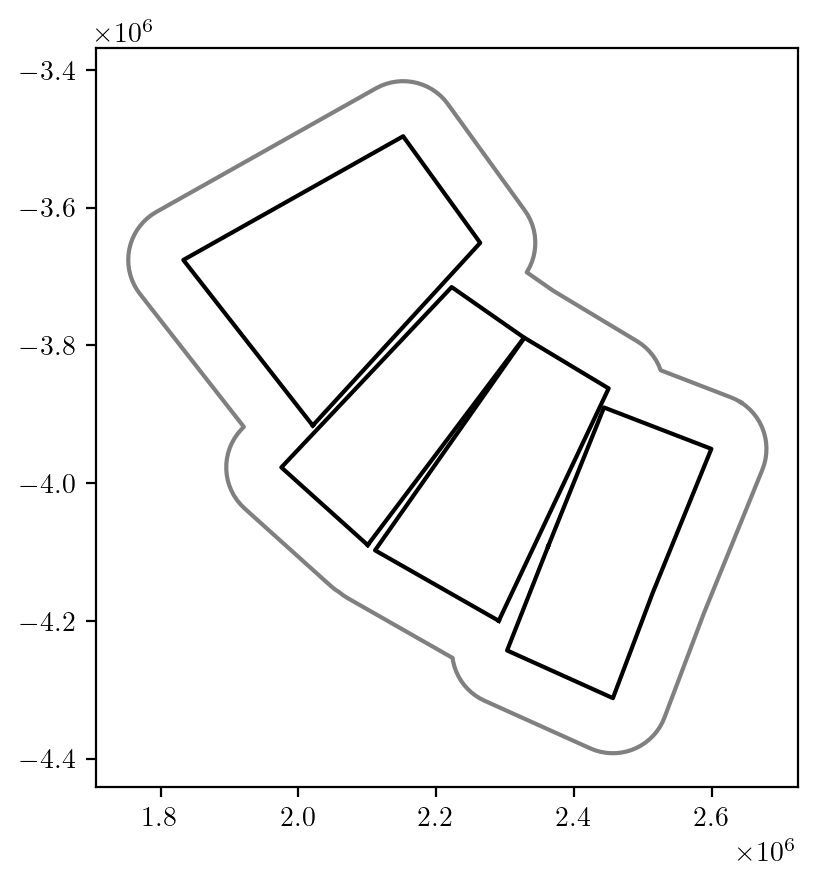

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal')
buffered_shpoly = shapely.geometry.Polygon()
for poly in saf_geometry["selection_polygons_xy"]:
    ax.plot(*poly.T, color='k')
    shpoly = shapely.geometry.Polygon(poly).buffer(R)
    buffered_shpoly = buffered_shpoly.union(shpoly)

x,y = buffered_shpoly.exterior.coords.xy
ax.plot(x,y,color='gray')
buffered_poly = np.array(x[:-1]), np.array(y[:-1])

## Determine Regional Distributions
First off, prepare some code for spatial filtering. So far, we have not checked for double entries to the data base. Also, we might want to remove data points that are too close to each other (circumventing the spatial clustering).

In [11]:
seed = 498267187

In [12]:
valid_points, used_data_entries, distributions, distribution_lola \
    = cached_call(random_global_R_disk_coverings, R, min_points,
                  hf_independent, buffered_poly, saf_geometry["proj_str"], dmin=DMIN_KM*1e3,
                  MAX_DRAW=10000000, N=200, seed=seed)

print("Number of distributions:  ",len(distributions))
print("Maximum distribution size:", max(d.size for d in distributions))

Number of distributions:   117
Maximum distribution size: 21


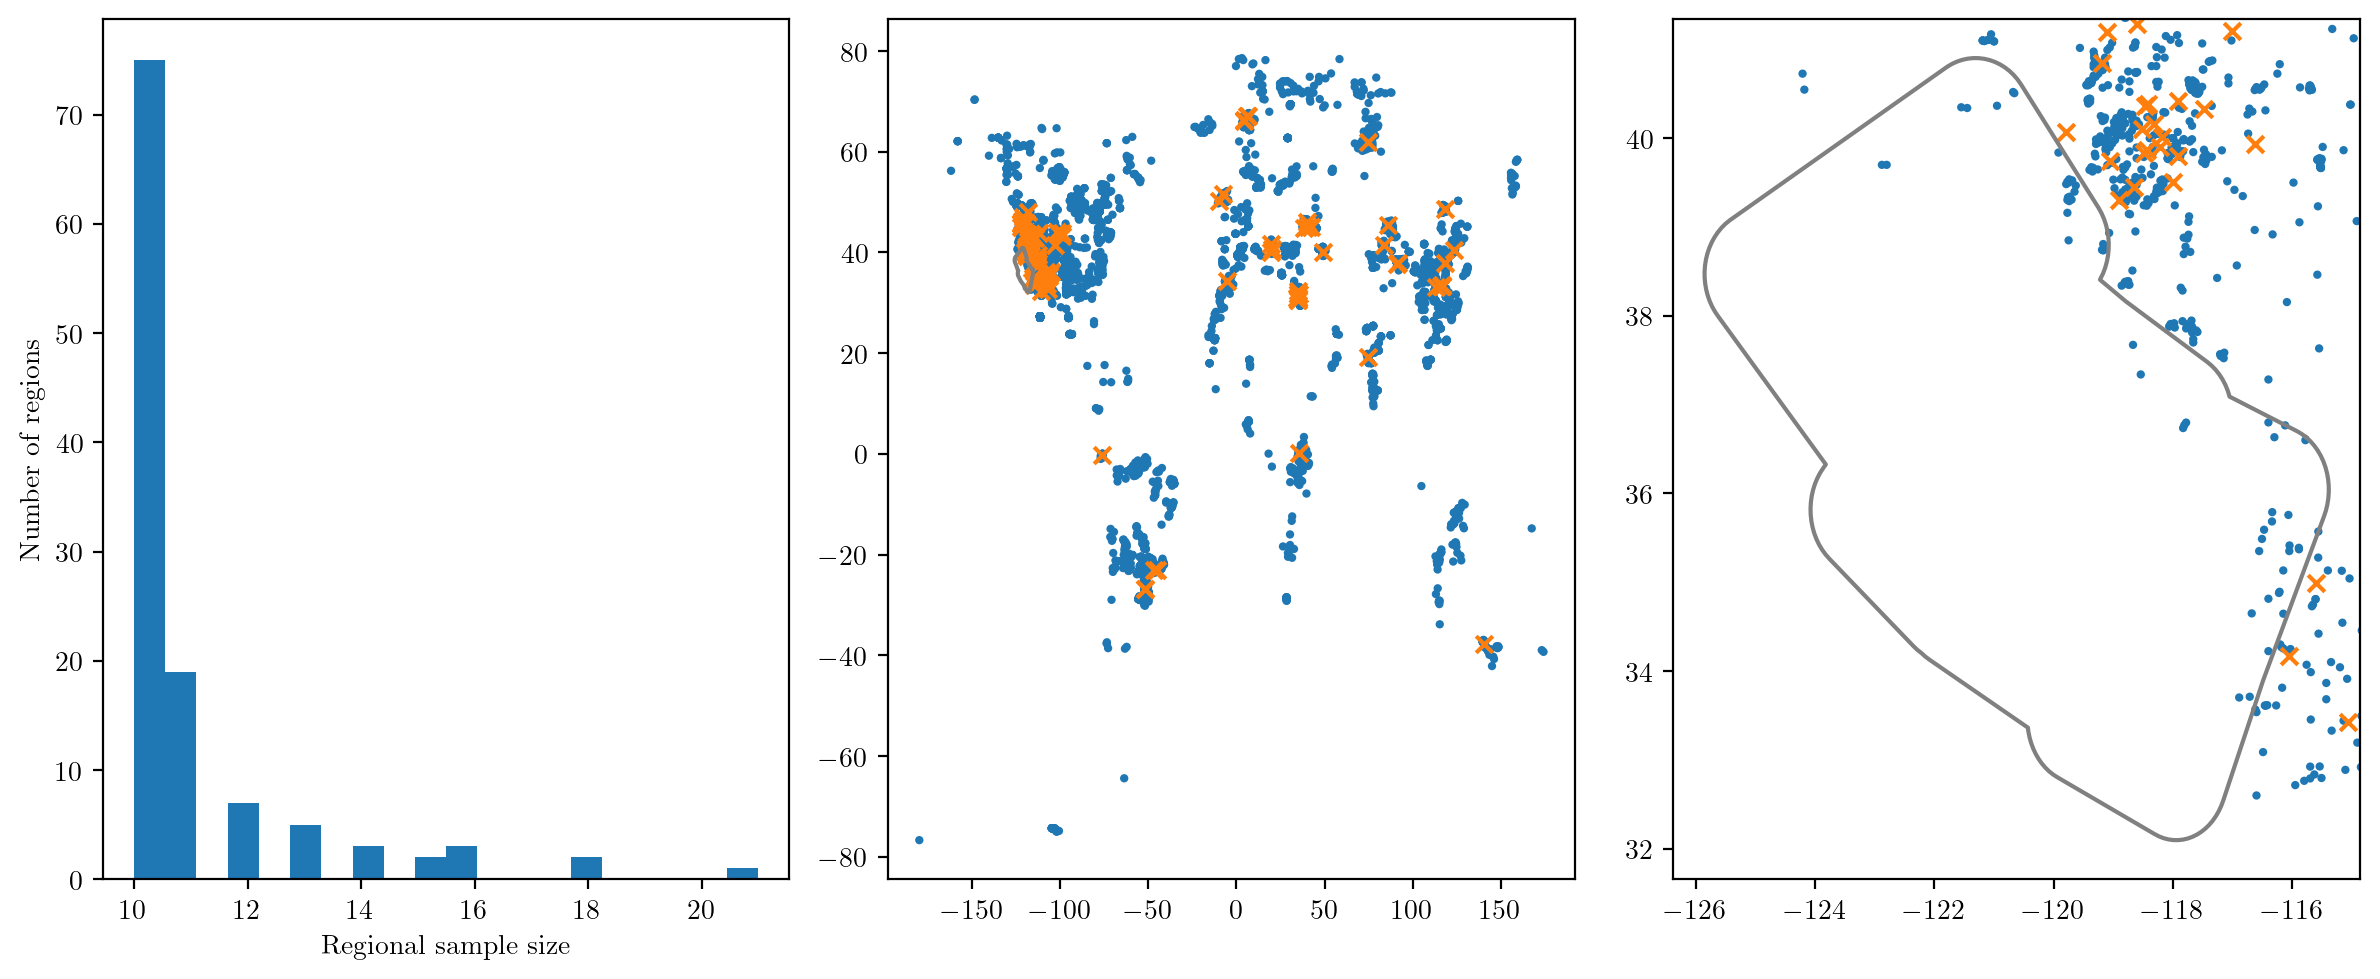

In [13]:
fig = plt.figure(figsize=(12,5))

# Histogram of sample size:
ax = fig.add_subplot(131)
ax.hist([d.size for d in distributions], bins=20)
ax.set_xlabel('Regional sample size')
ax.set_ylabel('Number of regions')

# Global distribution:
ax = fig.add_subplot(132)
ax.scatter(*hf_independent[:,1:3].T, marker='.', edgecolor='none')
ax.scatter(*np.array(valid_points).T, marker='x')
ax.plot(*proj_saf(x, y, inverse=True), color='gray')

# The study area:
ax = fig.add_subplot(133)
ax.plot(*proj_saf(x, y, inverse=True), color='gray')
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.scatter(*hf_independent[:,1:3].T, marker='.', edgecolor='none')
ax.scatter(*np.array(valid_points).T, marker='x')


Path('figures').mkdir(exist_ok=True)
fig.tight_layout()
fig.savefig('figures/03-RGRDC-sample-sizes-and-locations.pdf')

Mark the data entries that will be used in the later regional analysis:

In [14]:
j = 0
ude = []
for i,d in enumerate(distributions):
    Ni = d.size
    ude.append([int(local2lucazeau[k])
                for k in used_data_entries[j:j+Ni]])
    j += Ni

used_data_entries = ude

## Fit the Gamma Conjugate Prior
We compute the *minimum surprise estimate* (MSE) of the gamma conjugate prior given the distributions.
The MSE minimizes the Kullback-Leibler (KL) distance between conjugate prior $\phi(\alpha,\beta)$ and
the heat flow data.
In particular, for each aggregate heat flow distribution $Q_i = \{q_j\}_i$, a posterior probability
$\pi_i(\alpha, \beta)$ is computed from an "uninformed" prior ($p_i=1$, $s_i=n_i=v_i=0$, see Miller, 1980).
Then, the maximum KL distance $d$ from the conjugate prior to any of the $\pi_i$,
$$
    d = \max\limits_i \left\{ \,\int\limits_{\alpha_\mathrm{min}}^\infty\!\mathrm{d}\alpha
                              \int\limits_{0}^\infty\!\mathrm{d}\beta \,
                              \pi_i(\alpha,\beta)
                              \ln\left(\frac{\pi_i(\alpha,\beta)}{\phi(\alpha,\beta)}\right)     
                      \right\}
$$
is minimized using the SciPy L-BFGS-B optimizer to yield the parameter estimates $\hat{p}$, $\hat{s}$,
$\hat{n}$, $\hat{\nu}$.

In [16]:
gcp = GammaConjugatePrior.minimum_surprise_estimate(distributions, verbose=True)
gcp

Optimizing...
Optimization finished.
Result:
     fun: 4.496167948277268
    funl: array([ 4.49616795,  7.21246459,  7.56094327, 39.171555  ])
 message: 'Optimization terminated successfully.'
    nfev: 3194
     nit: 3
   nlfev: 3097
   nlhev: 0
   nljev: 0
 success: True
       x: array([ 9.25059094e-01,  1.53730167e+01, -2.73902616e+02,  2.18476537e-01])
      xl: array([[ 9.25059094e-01,  1.53730167e+01, -2.73902616e+02,
         2.18476537e-01],
       [ 3.40546552e+00,  5.26485373e+01, -6.78123448e+00,
         8.17063132e-01],
       [ 1.16063387e+00,  1.65102275e+01, -6.09962621e+00,
         2.85022127e-01],
       [ 1.49466747e+01,  2.29864325e+02, -3.97680283e+00,
         3.47606958e+00]])


GammaConjugatePrior(p=2.5220172925228335, s=15.373016724405591, n=0.2184765374862465, ν=0.2184765374862465, amin=1.0)

##### Inspect the results

Plot the cost function surrounding the minimum:

In [17]:
GCP_i = [GammaConjugatePrior(1, 0, 0, 0).updated(dist) for dist in distributions]

def cost_function(p, s, n, v):
    try:
        gcp = GammaConjugatePrior(p, s, n, v)
        return max(gcp.kullback_leibler(gcpi) for gcpi in GCP_i)
    except:
        return np.NaN

In [21]:
P = np.linspace(np.exp(gcp.lp)-0.01, np.exp(gcp.lp)+0.01, 51)
S = np.linspace(gcp.s-0.05, gcp.s+0.05, 50)
C = np.array([[cost_function(p, s, gcp.n, gcp.v) for p in P] for s in S])

Found inf result in integrand for amax = 0, a = 6.27861e+15.
Found inf result in integrand for amax = 0, a = 9.12741e+42.
Found inf result in integrand for amax = 0, a = 3.7516e+09.
Found inf result in integrand for amax = 0, a = 1.13226e+26.
Found inf result in integrand for amax = 0, a = 2.8588e+33.
Found inf result in integrand for amax = 0, a = 6.27861e+15.
Found inf result in integrand for amax = 0, a = 9.12741e+42.
Found inf result in integrand for amax = 0, a = 3.7516e+09.
Found inf result in integrand for amax = 0, a = 1.13226e+26.
Found inf result in integrand for amax = 0, a = 2.8588e+33.
Found inf result in integrand for amax = 0, a = 6.27861e+15.
Found inf result in integrand for amax = 0, a = 9.12741e+42.
Found inf result in integrand for amax = 0, a = 3.7516e+09.
Found inf result in integrand for amax = 0, a = 1.13226e+26.
Found inf result in integrand for amax = 0, a = 2.8588e+33.
Found inf result in integrand for amax = 0, a = 6.27861e+15.
Found inf result in integrand 

In [20]:
N = np.linspace(gcp.n-0.01, gcp.n+0.01, 51)
V = np.linspace(gcp.v-0.01, gcp.v+0.01, 50)
C2 = np.array([[cost_function(np.exp(gcp.lp), gcp.s, n, v)
               if (n > v and n-v < 0.005) else np.NaN for n in N] for v in V])

In [25]:
from matplotlib.colors import Normalize

In [74]:
rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'both',
          'axes.gri

In [98]:
from cmcrameri.cm import *
from matplotlib.patches import Polygon

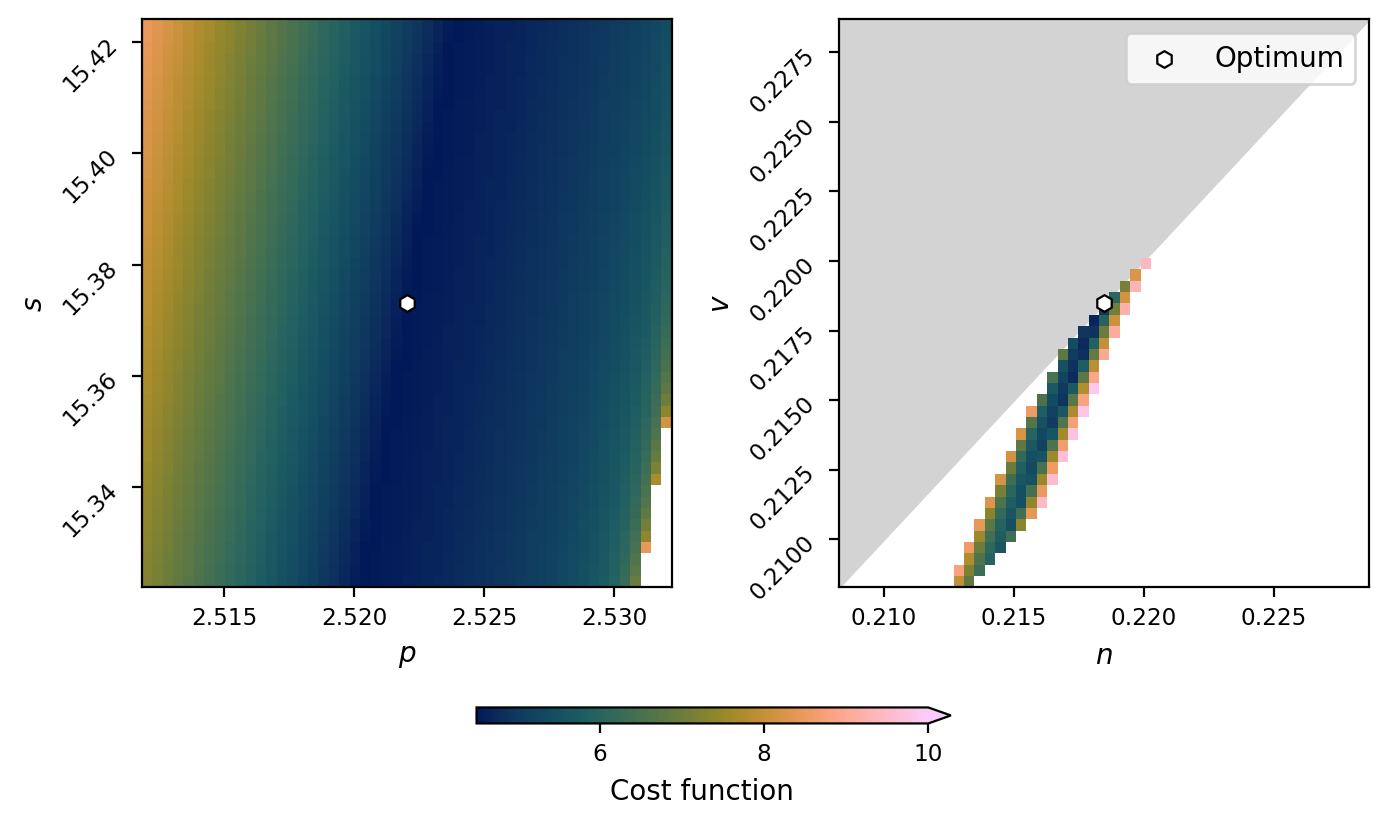

In [113]:
with plt.rc_context({"font.size" : 10, "xtick.labelsize" : "small", "ytick.labelsize" : "small"}):
    fig = plt.figure(figsize=(6.975, 4.0))
    #ax_bg = fig.add_axes((0,0,1,1))
    cax = fig.add_axes((0.33, 0.11, 0.34, 0.02))
    ax = fig.add_axes((0.09, 0.28, 0.38, 0.71))
    Cmax = 10.0
    mask = C < Cmax
    Cp = C.copy()
    Cp[~mask] = np.NaN
    mask = C2 < Cmax
    Cp2 = C2.copy()
    Cp2[~mask] = np.NaN
    norm = Normalize(min(Cp[mask].min(),Cp2[mask].min()), Cmax)
    h = ax.pcolormesh(P, S, Cp, norm=norm, cmap=batlow)
    ax.scatter(np.exp(gcp.lp), gcp.s, marker='h', facecolor='w', edgecolor='k', linewidth=0.8,
               label='Optimum')
    #ax.scatter(P[imin], S[jmin], marker='s', facecolor='none', edgecolor='tab:orange')
    #fig.colorbar(h);
    ax.set_xlabel('$p$')
    ax.set_ylabel('$s$');
    for tick in ax.get_yticklabels():
        tick.set_rotation(45)
    ax = fig.add_axes((0.59, 0.28, 0.38, 0.71))
    h = ax.pcolormesh(N, V, Cp2, norm=norm, cmap=batlow)
    ax.scatter(gcp.n, gcp.v, marker='h', facecolor='w', edgecolor='k', linewidth=0.8,
               label='Optimum')
    ax.legend()
    #ax.scatter(N[kmin], V[lmin], marker='s', facecolor='none', edgecolor='tab:orange')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.set_xlim((min(xlim[0],ylim[0]), max(xlim[1],ylim[1])))
    ax.set_ylim((min(xlim[0],ylim[0]), max(xlim[1],ylim[1])))
    ax.add_patch(Polygon([(xlim[0],ylim[0]), (xlim[1],ylim[1]), (xlim[0], ylim[1])], color='lightgray',zorder=0))
    fig.colorbar(h, cax=cax, orientation='horizontal', extend='max')
    cax.set_xlabel('Cost function')
    ax.set_xlabel('$n$')
    ax.set_ylabel('$v$');
    for tick in ax.get_yticklabels():
        tick.set_rotation(45);
    
    fig.savefig('figures/03-Optimization-Result-psnv.pdf')

In [114]:
Ctmp = C.copy()
Ctmp[np.isnan(Ctmp)] = np.inf
print("final:      ",cost_function(np.exp(gcp.lp), gcp.s, gcp.n, gcp.v))
print("raster best:",Ctmp.min())
imin, jmin = np.unravel_index(np.argmin(Ctmp), Ctmp.shape)

final:       4.496167948277261
raster best: 4.497152546806248


In [115]:
Ctmp = C2.copy()
Ctmp[np.isnan(Ctmp)] = np.inf
print("final:      ",cost_function(np.exp(gcp.lp), gcp.s, gcp.n, gcp.v))
print("raster best:",Ctmp.min())
kmin, lmin = np.unravel_index(np.argmin(Ctmp), Ctmp.shape)

final:       4.496167948277261
raster best: 4.653807877946505


Plot the result:

In [116]:
from zeal2022hf import kindlmann_r, kindlmann

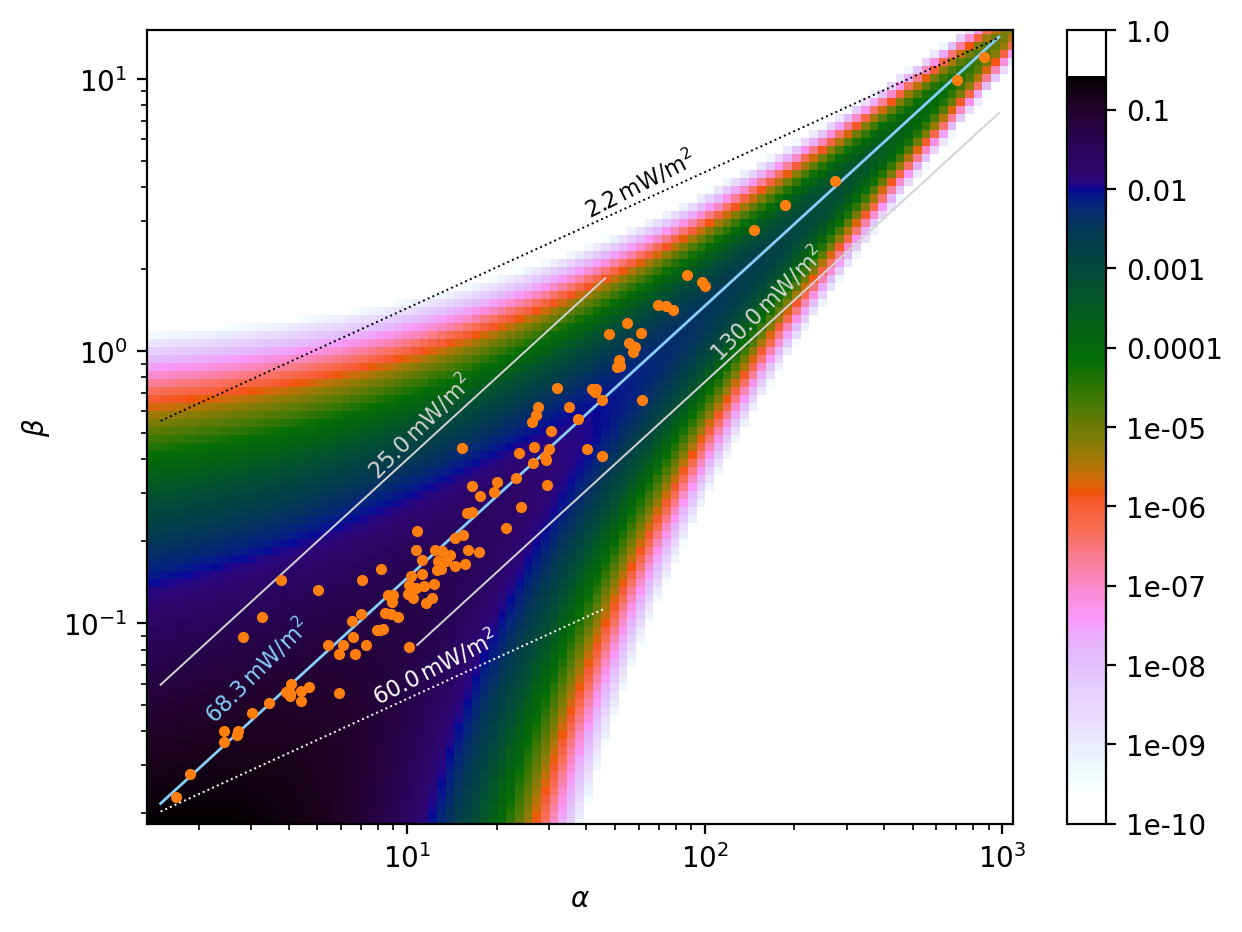

In [117]:
fig = plt.figure()
ax = fig.add_subplot(111)
gcp.visualize(ax, distributions, cmap=kindlmann_r,
              q_plot = [(25., 1.0, 50.0, 'lightgray'), (130., 10.0, 1000, 'lightgray')],
              qstd_plot = [2.2, (60., 1.1, 50, 'w')])
fig.tight_layout()
fig.savefig('figures/03-Gamma-Conjugate-Prior.pdf')

## References:
> Lucazeau, F. (2019). Analysis and mapping of an updated terrestrial heat
>    flow data set. Geochemistry, Geophysics, Geosystems, 20, 4001– 4024.
>    https://doi.org/10.1029/2019GC008389

### License
```
A notebook to determine the parameters of the gamma conjugate prior
from regional aggregate heat flow distributions.

This file is part of the REHEATFUNQ model.

Author: Malte J. Ziebarth (ziebarth@gfz-potsdam.de)

Copyright © 2019-2022 Deutsches GeoForschungsZentrum Potsdam,
            2022 Malte J. Ziebarth
            

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.
```